In [392]:
# Import libraries
import pandas as pd
import numpy as np
import pandas_ta as ta
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
timeframe = "M15"
symbols = ["SPX500"]
systems = ["Strat"]
starting_balance = 100
risk_per_trade = 0.02
trade_direction = "long"
dema_length = 200
st_atr_period = 12
st_multiplier = 3.0
atr_stop = False

In [394]:
# Load CSV File
def get_price_data(symbol):
    df = pd.read_csv(f"../data/{symbol}_{timeframe}.csv", parse_dates=['Datetime'], index_col='Datetime')
    df.index = pd.to_datetime(df.index, utc=True).tz_convert("America/New_York")  # Keeps local timezone without converting to UTC
    return df

In [395]:
def calculate_inputs(df):

    # Calculate DEMA using pandas_ta
    df['DEMA'] = ta.dema(df['Close'], length=dema_length)

    # Calculate Supertrend using pandas_ta
    supertrend = ta.supertrend(df['High'], df['Low'], df['Close'], length=st_atr_period, multiplier=st_multiplier)
    # Extract the direction of the trend
    df['Supertrend_Signal'] = supertrend[f'SUPERTd_{st_atr_period}_{st_multiplier}']
    df['Supertrend_Upper'] = supertrend[f'SUPERTs_{st_atr_period}_{st_multiplier}']
    df['Supertrend_Lower'] = supertrend[f'SUPERTl_{st_atr_period}_{st_multiplier}']
    
    # Compute Bollinger Bands
    # Calculate VWMA (Volume-Weighted Moving Average)
    df['VWMA'] = ta.vwma(df['Close'], df['Volume'], length=20)

    # Calculate Standard Deviation based on 'Close' prices
    std_dev = df['Close'].rolling(window=20).std()

    # Calculate Upper and Lower Bands using VWMA as the basis
    df['BBL'] = df['VWMA'] - (std_dev)  # Lower Band
    df['BBU'] = df['VWMA'] + (std_dev)  # Upper Band

    # Compute ATR for stop loss
    df["ATR"] = df.ta.atr(length=14)

    return df

In [396]:
def generate_signals(df, s, atr_sl, tp_ratio):
    
    # Various entry conditions
    c1_long = (df['Supertrend_Signal'] == 1) & (df['Supertrend_Signal'].shift(1) == -1)
    c2_long = df['Close'] > df['DEMA']

    c1_short = (df['Supertrend_Signal'] == -1) & (df['Supertrend_Signal'].shift(1) == 1)
    c2_short = df['Close'] < df['DEMA']

    c3 = df['DEMA'].notna()

    #generate entries and exits
    #entry is taken if the conditions were met at yesterday's close
    # Entries depend on the strategy
    if s == "Strat":
        # default entry rules
        if trade_direction == "long":
            df[f"{s}_Signal"] = c1_long.shift(1) & c2_long.shift(1) & c3.shift(1) # default strategy rules
        elif trade_direction == "short":
            df[f"{s}_Signal"] = c1_short.shift(1) & c2_short.shift(1) & c3.shift(1)# default strategy rules

    if trade_direction == "long":
        # Compute ATR-based Stop Loss
        if atr_stop:
            df['SL'] = df['Open'] - df['ATR'].shift(1) * atr_sl
        else:
            df['SL'] = df['Supertrend_Lower'].shift(1)
        
        stop_dist = df['Open'] - df['SL']
        df['TP'] = df['Open'] + stop_dist * tp_ratio * 1000 # Set the TP to a huge value to use other exit strategies

        df['Exit'] = (df['Supertrend_Signal'] == -1) | (df['Close'] > df['BBU'])

    elif trade_direction == "short":
        if atr_stop:
            df['SL'] = df['Open'] + df['ATR'].shift(1) * atr_sl 
        else:
            df['SL'] = df['Supertrend_Upper'].shift(1)
    
        stop_dist = df['SL'] - df['Open']
        df['TP'] = df['Open'] - stop_dist * tp_ratio * 1000 # Set the TP to a huge value to use other exit strategies
   
        df['Exit'] = (df['Supertrend_Signal'] == 1) | (df['Close'] < df['BBL'])

    return df

In [397]:
def generate_trades(df, s):
    #create empty list for trades
    trades_list = []
    trade_open = False
    open_change = {}
    balance = starting_balance
    equity = starting_balance
    balance_history = []
    equity_history = []
    
    #iterate through rows to work out entries and exits
    for i, row in df.iterrows():
        #if there is currently no trade
        if not trade_open:
            #check if long signal was generated and enter at the same time
            if row[f"{s}_Signal"] == True:
                entry_date = i
                entry_price = row.Open
                sl = row.SL
                tp = row.TP
                high = row.High
                close = row.Close
                # Calculate position size based on risk percentage
                risk_amount = balance * risk_per_trade
                if entry_price == sl:
                    position_size = 0.01
                else:
                    position_size = risk_amount / abs(entry_price - sl)  # Position size in units
                trade_open = True
        #check if a trade is already open
        if trade_open:
            #get price values
            prev_close = close
            low = row.Low
            high = row.High
            close = row.Close

            # Calculate unrealized PnL
            if trade_direction == "long":
                floating_pnl = (high - entry_price) * position_size
                equity = balance + floating_pnl  # Update equity dynamically

                # Calculate unrealized PnL
                #check if stop is hit
                if low <= sl:
                    #first check for a gap down
                    if row.Open <= sl:
                        exit_price = row.Open
                    else:
                        exit_price = sl
                    trade_open = False

                # Now do the same check for take profit
                elif high >= tp:
                    #first check for a gap up
                    if row.Open >= tp:
                        exit_price = row.Open
                    else:
                        exit_price = tp
                    trade_open = False

                elif getattr(row, "Exit", False):
                    exit_price = row.Close  # Close at the market close price
                    trade_open = False

            elif trade_direction == "short":
                floating_pnl = (entry_price - low) * position_size
                equity = balance + floating_pnl  # Update equity dynamically

                # Calculate unrealized PnL
                #check if stop is hit
                if high >= sl:
                    #first check for a gap down
                    if row.Open >= sl:
                        exit_price = row.Open
                    else:
                        exit_price = sl
                    trade_open = False

                # Now do the same check for take profit
                elif low <= tp:
                    #first check for a gap up
                    if row.Open <= tp:
                        exit_price = row.Open
                    else:
                        exit_price = tp
                    trade_open = False

                elif getattr(row, "Exit", False):
                    exit_price = row.Close  # Close at the market close price
                    trade_open = False

            if not trade_open: # If trade has been closed
                exit_date = i
                trade_open = False
                if trade_direction == "long":
                    pnl = (exit_price - entry_price) * position_size  # PnL in currency terms
                elif trade_direction == "short":
                    pnl = -1 * (exit_price - entry_price) * position_size  # PnL in currency terms
                balance += pnl  # Update balance with PnL

                #store trade data in a list
                trade = [entry_date, entry_price, exit_date, exit_price, position_size, pnl, balance, True]
                #append trade to overall trade list
                trades_list.append(trade)

        # Store balance and equity
        balance_history.append(balance)
        equity_history.append(equity)

    trades = pd.DataFrame(trades_list, columns=["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Position_Size", "PnL", "Balance", "Sys_Trade"])
    
    #calculate return of each trade as well as the trade duration
    #trades[f"{s}_Return"] = trades.Exit_Price / trades.Entry_Price
    trades[f"{s}_Return"] = trades.Balance / trades.Balance.shift(1)
    dur = []
    for i, row in trades.iterrows():
        d1 = row.Entry_Date
        d2 = row.Exit_Date
        dur.append(np.busday_count(d1.date(), d2.date()) + 1)#Add 1 because formula doesn't include the end date otherwise
    
    trades[f"{s}_Duration"] = dur

    #create a new dataframe with an index of exit dfs
    returns = pd.DataFrame(index=trades.Exit_Date)
    #create a new dataframe with an index of entries to track entry price
    entries = pd.DataFrame(index=trades.Entry_Date)

    entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
    #add the Return column to this new data frame
    returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
    returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
    returns[f"{s}_Duration"] = pd.Series(trades[f"{s}_Duration"]).values
    returns[f"{s}_PnL"] = pd.Series(trades.PnL).values
    returns[f"{s}_Balance"] = pd.Series(trades.Balance).values

    #add the returns from the trades to the main data frame
    df = pd.concat([df, returns, entries], axis=1)
    #fill all the NaN return values with 1 as there was no profit or loss on those days
    df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
    #fill all the NaN trade values with False as there was no trade on those days
    df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
    
    #use the updated balance and equity variables
    df[f"{s}_Bal"] = pd.Series(balance_history, index=df.index).ffill()
    df[f"{s}_Equity"] = pd.Series(equity_history, index=df.index).ffill()

    active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
    df[f"{s}_In_Market"] = df[f"{s}_Trade"].copy()
    #populate trades column based on duration
    for count, t in enumerate(active_trades):
        if t == True:
            dur = df[f"{s}_Duration"].iat[count]
            for i in range(int(dur)):
                #starting from the exit date, move backwards and mark each trading day
                df[f"{s}_In_Market"].iat[count - i] = True

    return df, trades

In [398]:
def backtest(price, sl, tp_ratio):
    #calculate strategy inputs
    price = calculate_inputs(price)
    for s in systems:
        #generate signals
        price = generate_signals(price, s, sl, tp_ratio)

        #generate trades
        price, trades = generate_trades(price, s)

    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price, trades

In [399]:
results = []
result_keys = []
result_key = ""
prog = 0
sl_range = np.arange(1.0, 1.5, 0.5)
tp_range = np.arange(3.0, 3.5, 0.5)
max_prog = len(symbols) * len(sl_range) * len(tp_range)
start_time = time.time()
for sym in symbols:
    price = get_price_data(sym)
    for sl in sl_range:
        for tp_ratio in tp_range:
            result, trades = backtest(price, sl, tp_ratio)
            results.append(result)
            result_key = f"{sym}_sl{sl}_tp{tp_ratio}"  # String format
            result_keys.append(result_key)
            prog += 1
            clear_output(wait=True)
            print(f"Progress: {round((prog / max_prog) * 100)} %")
end_time = time.time()
print(f"Total Time Elapsed: {end_time - start_time} s")

Progress: 100 %
Total Time Elapsed: 0.3354768753051758 s


In [400]:
def get_metrics(system, data):
    rfr = 0.03 # risk free return rate of 3%
    if timeframe == "daily":
        N = 252 # number of trading days per year
    elif timeframe == "hourly":
        N = 252 * 6.5 # number of trading hours per year (assuming 9:30 - 16:00 for NYSE)
    elif timeframe == "M30":
        N = 252 * 6.5 * 2       
    elif timeframe == "M15":
        N = 252 * 6.5 * 4
    elif timeframe == "M5":
        N = 252 * 6.5 * 12
    metrics = {}
    years = (data.index[-1] - data.index[0]).days / 365.25
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_dd)
    periods_in_market = data[f"{system}_In_Market"].sum()
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round(periods_in_market / len(data) * 100, 2)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)
    gaps = (data.Open > data[f"{system}_Entry_Price"]).sum()
    non_gaps = (data.Open <= data[f"{system}_Entry_Price"]).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #sharpe ratio
    ret = data[f"{system}_Bal"].pct_change().dropna()
    excess_ret = ret - rfr/N
    sharpe = np.sqrt(N) * excess_ret.mean() / excess_ret.std()

    #sortino ratio
    downside_std = excess_ret[excess_ret < 0].std()
    sortino = np.sqrt(N) * excess_ret.mean() / downside_std
        
    # Calculate longest trade and average trade duration
    longest_trade_duration = 0
    avg_trade_duration = 0
    if f"{system}_Duration" in data:
        longest_trade_duration = data[f"{system}_Duration"].max()
        avg_trade_duration = data[f"{system}_Duration"].mean()

    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    #metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    #metrics["Time_in_Market"] = round(tim, 2)
    #metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    #metrics["Return_Over_Drawdown"] = round(rod, 2)
    #metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Sharpe"] = round(sharpe, 2)
    metrics["Sortino"] = round(sortino, 2)
    metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    #metrics["Gap"] = round(gaps)
    #metrics["No_Gap"] = round(non_gaps)
    #metrics["Wins"] = round(wins, 2)
    #metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    #metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    #metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    #metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    #metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr

    # Add Longest and Average Trade Duration
    metrics["Longest_Trade_Duration"] = longest_trade_duration
    #metrics["Avg_Trade_Duration"] = round(avg_trade_duration, 2)

    return metrics

In [401]:
sys_metrics = {}
for count, res in enumerate(results):
    for s in systems:
        for sl in sl_range:
            for tp_ratio in tp_range:
                sys_metrics[f"{s}_{result_keys[count]}"] = get_metrics(s, res)
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)

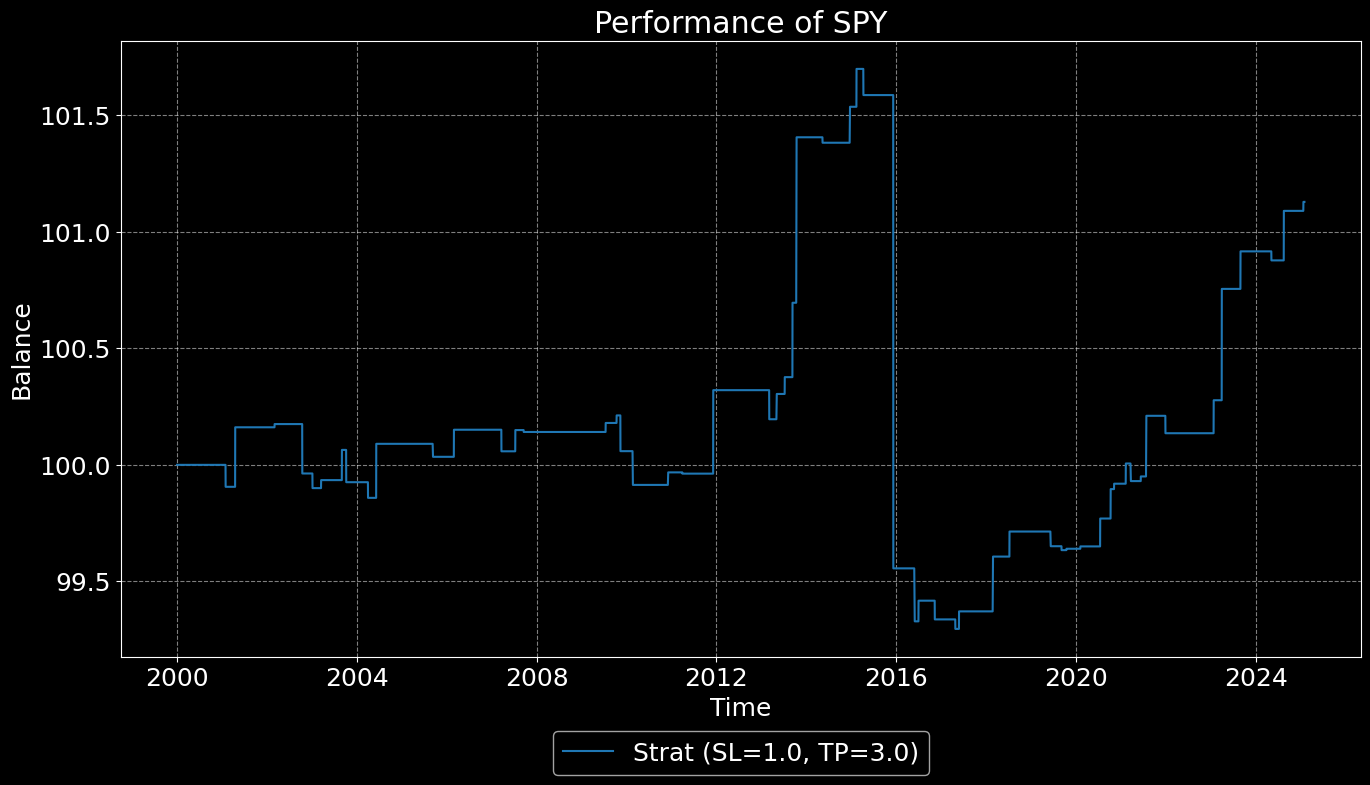

In [402]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 18})

#colours = ["tab:olive", "tab:blue", "tab:purple", "tab:orange", "tab:green", "tab:cyan", "tab:red", "tab:gray", "tab:pink"]
cmap = plt.get_cmap("tab10")  # You can try 'tab20', 'viridis', 'plasma', etc.

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(f"Performance of {sym}")

    legend_entries = []  # Store legend labels
    total_lines = len(tp_range) * len(sl_range) * len(systems)  # Total lines to plot
    colours = [cmap(i / total_lines) for i in range(total_lines)]  # Generate distinct colors
    
    colour_idx = 0  # To cycle through colors if needed

    for sl in sl_range:
        for tp_ratio in tp_range:
            for c, s in enumerate(systems):
                # Generate a unique index for each (SL, TP) combination
                result_idx = count * len(sl_range) * len(tp_range) + list(sl_range).index(sl) * len(tp_range) + list(tp_range).index(tp_ratio)

                if result_idx >= len(results):  
                    continue  # Prevent out-of-bounds error

                label = f"{s} (SL={sl}, TP={tp_ratio})"  # Legend label
                color = colours[colour_idx % len(colours)]  # Cycle through colors
                
                plt.plot(results[result_idx][f"{s}_Bal"], color=color, label=label)
                legend_entries.append(label)

                colour_idx += 1  # Move to next color

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.xlabel("Time")
    plt.ylabel("Balance")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig("plot.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()




In [403]:
print(sys_metrics_df.to_string())

                        Strat_SPY_sl1.0_tp3.0
Start_Balance                          100.00
Final_Balance                          101.13
Annual_Return                            0.04
Max_Drawdown                            -2.36
Sharpe                                  -6.19
Sortino                                 -7.16
Signals                                 58.00
Trades                                  58.00
Winrate                                 60.71
Avg_RR                                   0.86
Longest_Trade_Duration                  15.00


In [404]:
# if trades is not None:
#     # Split index into 'Date' and 'Time' columns
#     trades['Entry_Date'] = pd.to_datetime(trades["Entry_Date"])
#     trades['Entry_Hour'] = trades['Entry_Date'].dt.hour

#     # Convert "Strat_Breakout_Return" to percentage
#     trades["Return_Percentage"] = (trades[f"{systems[-1]}_Return"] - 1) * 100

#     # Group by Hour and Calculate Average PnL
#     hourly_return = trades.groupby("Entry_Hour")["Return_Percentage"].mean()

#     # Group by Hour and Count Number of Trades
#     hourly_trades_count = trades.groupby("Entry_Hour")["Return_Percentage"].count()

#     # Combine the two results into a single DataFrame
#     hourly_stats = pd.DataFrame({
#         "Average_Return_Percentage": round(hourly_return, 2),
#         "Trades_Count": hourly_trades_count
#     })
#     #pd.set_option('display.float_format', '{:.6f}'.format)
#     # Display Result
#     print(hourly_stats)

In [405]:
# Extract unique years
years = result.index.year.unique()

# Calculate returns
data = []
for year in result.index.year.unique():
    yearly_data = result[result.index.year == year]
    
    for system in systems:
        start_bal = yearly_data[f"{system}_Bal"].iloc[0]
        end_bal = yearly_data[f"{system}_Bal"].iloc[-1]
        return_pct = ((end_bal - start_bal) / start_bal) * 100
        data.append([year, system, return_pct])

# Convert to DataFrame
returns_df = pd.DataFrame(data, columns=["Year", "System", "Return"])



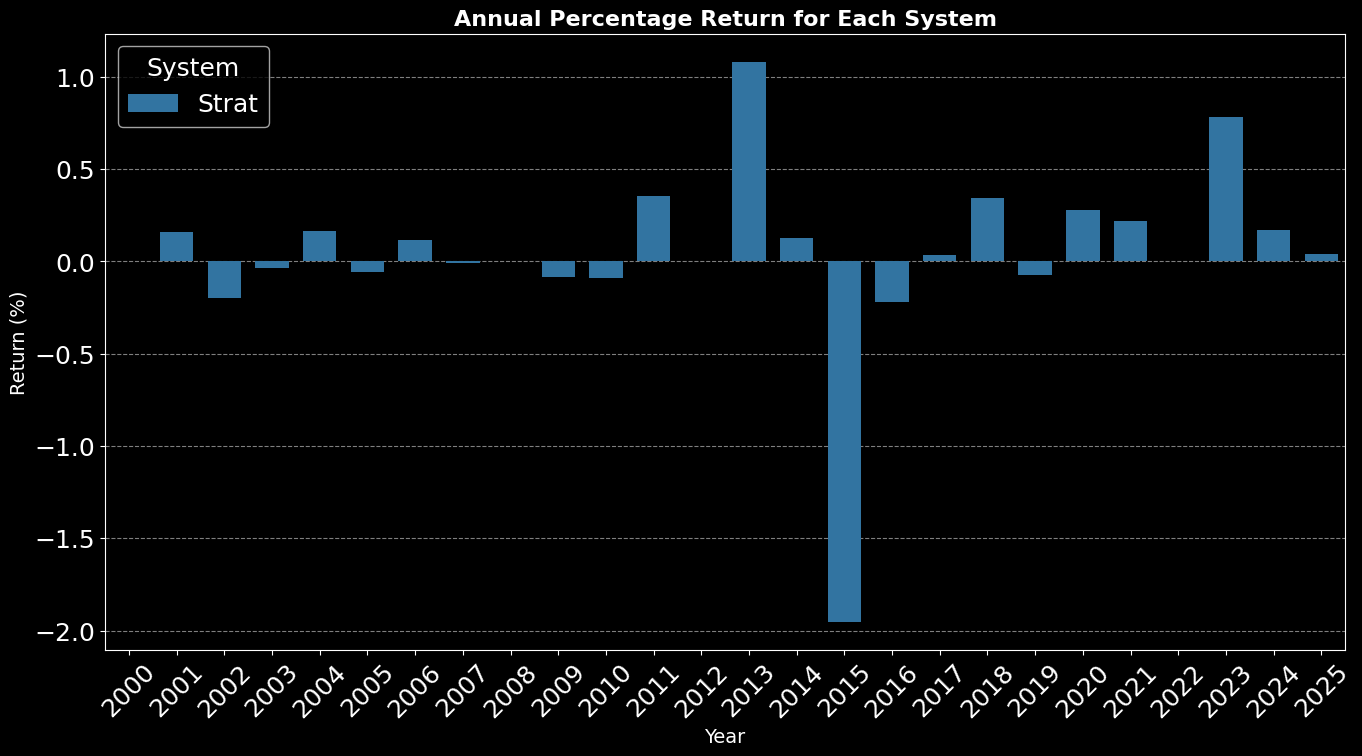

In [406]:
# Set up the figure
plt.figure(figsize=(16, 8))
sns.set_palette("tab10")

# Plot the bar chart
ax = sns.barplot(data=returns_df, x="Year", y="Return", hue="System", dodge=True, width=0.7)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add title and labels
plt.ylabel("Return (%)", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.title("Annual Percentage Return for Each System", fontsize=16, fontweight='bold')

# Gridlines
ax.set_axisbelow(True)
plt.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

# Legend
plt.legend(title="System", loc="upper left")

# Show the final chart
plt.show()


In [407]:
if trades is not None:
    trades.to_csv("trades.csv")
    result.to_csv("result.csv")